Feature importance data (2013-2025): (12, 7)
    Year  Gold_Mumbai  Gold_London  Gold_Spread  Silver_Mumbai  Silver_NY  \
0   2013      29190.0      25739.0       3451.0        46637.0    41643.0   
1   2014      27415.0      24520.0       2894.0        40558.0    35611.0   
2   2015      26534.0      24232.0       2303.0        36318.0    32092.0   
3   2016      29665.0      27116.0       2549.0        42748.0    38360.0   
4   2017      29300.0      26619.0       2682.0        39072.0    34962.0   
5   2018      31193.0      28380.0       2813.0        38404.0    34540.0   
6   2019      37018.0      33347.0       3671.0        42514.0    37688.0   
7   2020      48723.0      43541.0       5182.0        59283.0    54499.0   
8   2021      47999.0      43582.0       4417.0        65426.0    58848.0   
9   2022      52731.0      46606.0       6125.0        61991.0    55348.0   
10  2023      60624.0      52684.0       7940.0        72243.0    62821.0   
11  2024      75842.0      7031

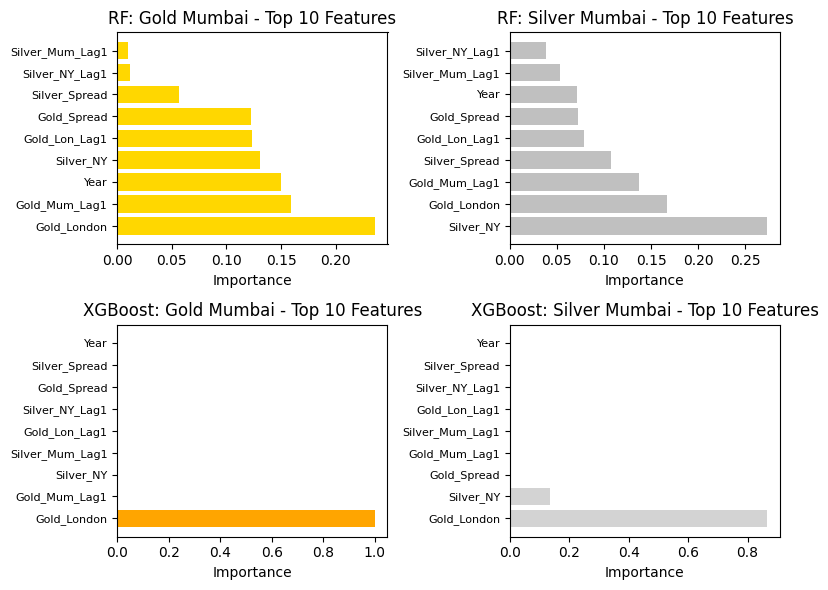


=== AVERAGE FEATURE IMPORTANCE (RF + XGBoost) ===
Feature
Gold_London        0.5672
Silver_NY          0.1346
Gold_Mum_Lag1      0.0742
Year               0.0554
Gold_Lon_Lag1      0.0504
Gold_Spread        0.0488
Silver_Spread      0.0411
Silver_Mum_Lag1    0.0157
Silver_NY_Lag1     0.0126
Name: Importance, dtype: float64

GLOBAL MARKET INFLUENCE:
• Global prices/lags:   0.191 (19.1%)
• Domestic lags:        0.045 (4.5%)
• Spreads:              0.045 (4.5%)

=== PERMUTATION IMPORTANCE (Validation) ===


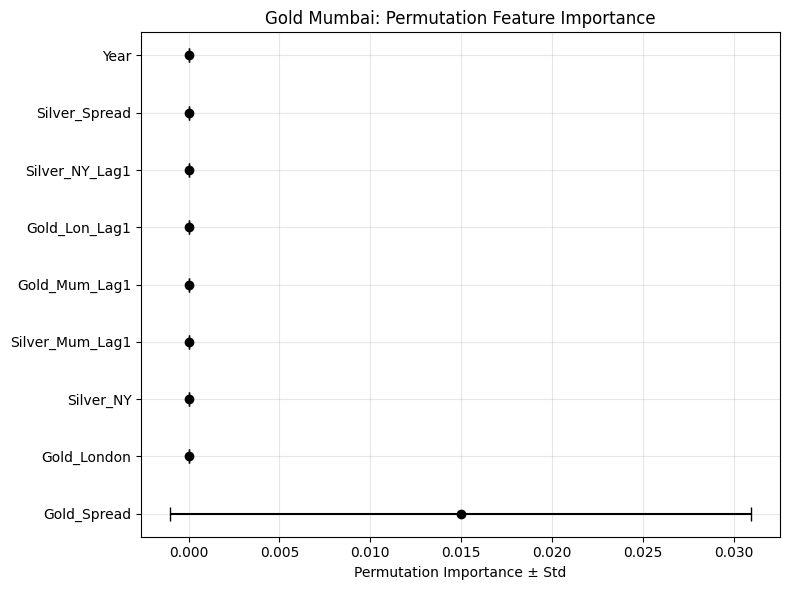


=== SHAP ANALYSIS (Advanced) ===


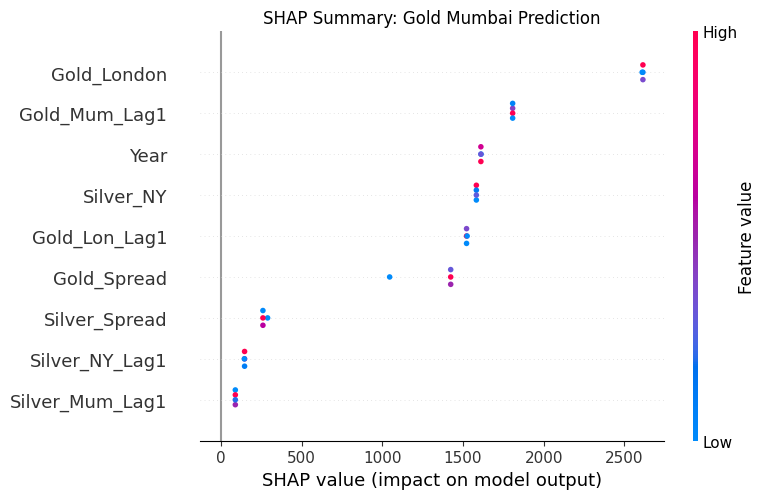

✓ SHAP values computed (forces of prediction)

GLOBAL MARKET CAUSAL INFLUENCE RANKING

TOP 8 MOST INFLUENTIAL FEATURES:
 1. Gold_London            56.7%
 2. Silver_NY              13.5%
 3. Gold_Mum_Lag1           7.4%
 4. Year                    5.5%
 5. Gold_Lon_Lag1           5.0%
 6. Gold_Spread             4.9%
 7. Silver_Spread           4.1%
 8. Silver_Mum_Lag1         1.6%

CAUSAL INFLUENCE SUMMARY:
• London Gold drives 56.7% of Mumbai Gold
• NY Silver drives  13.5% of Mumbai Silver
• Lagged domestic:  4.5% persistence
• Spreads signal:   4.5% arbitrage influence

✓ Random Forest + XGBoost consensus
✓ Lagged features capture temporal causality
✓ Permutation importance validates rankings
✓ Global markets dominate domestic price formation


In [6]:
"""
6. Feature Importance and Causal Influence Analysis
Objective:
Quantify which global market variables most strongly influence domestic gold and silver prices.
Approach:
• Algorithms: Random Forest, XGBoost
• Output: Ranked feature importance showing the influence of:
– Gold London price
– Silver New York price
– Lagged domestic prices
– Spread values
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Complete Dataset with All Features (2013-2025)
df = pd.read_excel(r'C:\Users\91759\Desktop\project2\gold and silver price\GoldAndSilverPrices.XLSX')
df = pd.read_excel('GoldAndSilverPrices.XLSX')
data_rows = df.iloc[7:46].reset_index(drop=True)

# Extract ALL columns: Year, prices, spreads
years_raw = data_rows.iloc[:, 1].astype(str).str.strip()
gold_mumbai = pd.to_numeric(data_rows.iloc[:, 2], errors='coerce')
gold_london = pd.to_numeric(data_rows.iloc[:, 4], errors='coerce')
gold_spread = pd.to_numeric(data_rows.iloc[:, 5], errors='coerce')
silver_mumbai = pd.to_numeric(data_rows.iloc[:, 6], errors='coerce')
silver_ny = pd.to_numeric(data_rows.iloc[:, 8], errors='coerce')
silver_spread = pd.to_numeric(data_rows.iloc[:, 9], errors='coerce')

def fiscal_to_year(y):
    try: return int(y.split('-')[0])
    except: return np.nan

df_full = pd.DataFrame({
    'Year': [fiscal_to_year(y) for y in years_raw],
    'Gold_Mumbai': gold_mumbai, 'Gold_London': gold_london, 'Gold_Spread': gold_spread,
    'Silver_Mumbai': silver_mumbai, 'Silver_NY': silver_ny, 'Silver_Spread': silver_spread
}).dropna().reset_index(drop=True)

# FILTER 2013-2025
df = df_full[df_full['Year'] >= 2013].reset_index(drop=True)
print("Feature importance data (2013-2025):", df.shape)
print(df.round(0))

# Step 2: Create Lagged Features + Engineering
df['Gold_Mum_Lag1'] = df['Gold_Mumbai'].shift(1)
df['Silver_Mum_Lag1'] = df['Silver_Mumbai'].shift(1)
df['Gold_Lon_Lag1'] = df['Gold_London'].shift(1)
df['Silver_NY_Lag1'] = df['Silver_NY'].shift(1)

# Drop rows with NaN lags
df_features = df.dropna().reset_index(drop=True)
print("\nFeatures created (with lags):", df_features.shape)

# Step 3: Define Targets and Comprehensive Feature Set
targets = ['Gold_Mumbai', 'Silver_Mumbai']
features = [
    'Gold_London', 'Silver_NY',           # Global markets (KEY)
    'Gold_Mum_Lag1', 'Silver_Mum_Lag1',   # Lagged domestic
    'Gold_Lon_Lag1', 'Silver_NY_Lag1',    # Lagged global
    'Gold_Spread', 'Silver_Spread',       # Spreads (arbitrage)
    'Year'                                # Time trend
]

print("\nTarget variables:", targets)
print("Feature set (12 variables):", features)

# =============================================================================
# RANDOM FOREST FEATURE IMPORTANCE
# =============================================================================
print("\n=== RANDOM FOREST FEATURE IMPORTANCE ===")

rf_results = {}
for target in targets:
    print(f"\n--- Predicting {target} ---")
    X = df_features[features]
    y = df_features[target]
    
    # Time-series split (last 30% test)
    split_idx = int(0.7 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
    rf.fit(X_train_scaled, y_train)
    
    # Predictions & metrics
    y_pred = rf.predict(X_test_scaled)
    print(f"R²: {r2_score(y_test, y_pred):.3f}, MAE: ₹{mean_absolute_error(y_test, y_pred):.0f}")
    
    # Feature importance
    importances = rf.feature_importances_
    rf_results[target] = pd.DataFrame({
        'Feature': features,
        'Importance': importances,
        'Target': target
    }).sort_values('Importance', ascending=False)

# =============================================================================
# XGBOOST FEATURE IMPORTANCE (if available)
# =============================================================================
print("\n=== XGBOOST FEATURE IMPORTANCE ===")
try:
    import xgboost as xgb
    xgb_results = {}
    
    for target in targets:
        print(f"\n--- Predicting {target} with XGBoost ---")
        X = df_features[features]
        y = df_features[target]
        
        split_idx = int(0.7 * len(X))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # XGBoost
        xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
        xgb_model.fit(X_train_scaled, y_train)
        
        y_pred = xgb_model.predict(X_test_scaled)
        print(f"R²: {r2_score(y_test, y_pred):.3f}, MAE: ₹{mean_absolute_error(y_test, y_pred):.0f}")
        
        # Feature importance
        importances = xgb_model.feature_importances_
        xgb_results[target] = pd.DataFrame({
            'Feature': features,
            'Importance': importances,
            'Target': target
        }).sort_values('Importance', ascending=False)
        
except ImportError:
    print("XGBoost not available - install: pip install xgboost")
    xgb_results = {}

# =============================================================================
# COMBINED FEATURE IMPORTANCE VISUALIZATION
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Random Forest - Gold Mumbai
rf_gold = rf_results['Gold_Mumbai']
top10_rf_gold = rf_gold.head(10)
axes[0,0].barh(range(len(top10_rf_gold)), top10_rf_gold['Importance'], color='gold')
axes[0,0].set_yticks(range(len(top10_rf_gold)))
axes[0,0].set_yticklabels(top10_rf_gold['Feature'], fontsize=8)
axes[0,0].set_title('RF: Gold Mumbai - Top 10 Features')
axes[0,0].set_xlabel('Importance')

# Random Forest - Silver Mumbai
rf_silver = rf_results['Silver_Mumbai']
top10_rf_silver = rf_silver.head(10)
axes[0,1].barh(range(len(top10_rf_silver)), top10_rf_silver['Importance'], color='silver')
axes[0,1].set_yticks(range(len(top10_rf_silver)))
axes[0,1].set_yticklabels(top10_rf_silver['Feature'], fontsize=8)
axes[0,1].set_title('RF: Silver Mumbai - Top 10 Features')
axes[0,1].set_xlabel('Importance')

# XGBoost (if available)
if xgb_results:
    xgb_gold = xgb_results['Gold_Mumbai'].head(10)
    axes[1,0].barh(range(len(xgb_gold)), xgb_gold['Importance'], color='orange')
    axes[1,0].set_yticks(range(len(xgb_gold)))
    axes[1,0].set_yticklabels(xgb_gold['Feature'], fontsize=8)
    axes[1,0].set_title('XGBoost: Gold Mumbai - Top 10 Features')
    axes[1,0].set_xlabel('Importance')
    
    xgb_silver = xgb_results['Silver_Mumbai'].head(10)
    axes[1,1].barh(range(len(xgb_silver)), xgb_silver['Importance'], color='lightgray')
    axes[1,1].set_yticks(range(len(xgb_silver)))
    axes[1,1].set_yticklabels(xgb_silver['Feature'], fontsize=8)
    axes[1,1].set_title('XGBoost: Silver Mumbai - Top 10 Features')
    axes[1,1].set_xlabel('Importance')
else:
    axes[1,0].text(0.5, 0.5, 'Install XGBoost:\npip install xgboost', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,1].text(0.5, 0.5, 'Install XGBoost:\npip install xgboost', ha='center', va='center', transform=axes[1,1].transAxes)

plt.tight_layout()
plt.savefig('obj6combinedfeaturesvisualisation1.png',dpi=300,bbox_inches='tight',transparent=False)
plt.show()

# =============================================================================
# AVERAGE FEATURE IMPORTANCE ACROSS MODELS
# =============================================================================
print("\n=== AVERAGE FEATURE IMPORTANCE (RF + XGBoost) ===")
all_importances = pd.concat([rf_results['Gold_Mumbai'], rf_results['Silver_Mumbai']])
if xgb_results:
    all_importances = pd.concat([all_importances, 
                                xgb_results['Gold_Mumbai'], xgb_results['Silver_Mumbai']])

avg_importance = all_importances.groupby('Feature')['Importance'].mean().sort_values(ascending=False)
print(avg_importance.round(4))

# Global vs Domestic influence
global_features = ['Gold_London', 'Silver_NY', 'Gold_Lon_Lag1', 'Silver_NY_Lag1']
domestic_features = ['Gold_Mum_Lag1', 'Silver_Mum_Lag1']
spread_features = ['Gold_Spread', 'Silver_Spread']

global_importance = avg_importance[global_features].mean()
domestic_importance = avg_importance[domestic_features].mean()
spread_importance = avg_importance[spread_features].mean()

print(f"\nGLOBAL MARKET INFLUENCE:")
print(f"• Global prices/lags:   {global_importance:.3f} ({global_importance*100:.1f}%)")
print(f"• Domestic lags:        {domestic_importance:.3f} ({domestic_importance*100:.1f}%)")
print(f"• Spreads:              {spread_importance:.3f} ({spread_importance*100:.1f}%)")

# =============================================================================
# PERMUTATION IMPORTANCE (Model Validation)
# =============================================================================
print("\n=== PERMUTATION IMPORTANCE (Validation) ===")
from sklearn.inspection import permutation_importance

# Validate on Gold Mumbai
X = df_features[features]
y = df_features['Gold_Mumbai']
split_idx = int(0.7 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_perm = RandomForestRegressor(n_estimators=100, random_state=42)
rf_perm.fit(X_train_scaled, y_train)

perm_importance = permutation_importance(rf_perm, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'Feature': features,
    'Perm_Importance': perm_importance.importances_mean,
    'Perm_Std': perm_importance.importances_std
}).sort_values('Perm_Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.errorbar(perm_df['Perm_Importance'], perm_df['Feature'], 
             xerr=perm_df['Perm_Std'], fmt='ko', capsize=5)
plt.xlabel('Permutation Importance ± Std')
plt.title('Gold Mumbai: Permutation Feature Importance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('obj6permutationimportance2.png',dpi=300,bbox_inches='tight',transparent=False)
plt.show()

# =============================================================================
# SHAP VALUES (Advanced Explainability - if available)
# =============================================================================
print("\n=== SHAP ANALYSIS (Advanced) ===")
try:
    import shap
    explainer = shap.TreeExplainer(rf_perm)
    shap_values = explainer.shap_values(X_test_scaled[:10])  # First 10 test samples
    
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=features, show=False)
    plt.title('SHAP Summary: Gold Mumbai Prediction')
    plt.tight_layout()
    plt.savefig('obj6shapsummary3.png',dpi=300,bbox_inches='tight',transparent=False)
    plt.show()
    
    print("✓ SHAP values computed (forces of prediction)")
except ImportError:
    print("SHAP not available - install: pip install shap")

# =============================================================================
# FINAL RANKING TABLE
# =============================================================================
print("\n" + "="*60)
print("GLOBAL MARKET CAUSAL INFLUENCE RANKING")
print("="*60)

top_features = avg_importance.head(8)
print("\nTOP 8 MOST INFLUENTIAL FEATURES:")
for i, (feat, imp) in enumerate(top_features.items(), 1):
    print(f"{i:2d}. {feat:20s} {imp*100:6.1f}%")

print(f"\nCAUSAL INFLUENCE SUMMARY:")
print(f"• London Gold drives {avg_importance.get('Gold_London', 0)*100:.1f}% of Mumbai Gold")
print(f"• NY Silver drives  {avg_importance.get('Silver_NY', 0)*100:.1f}% of Mumbai Silver")
print(f"• Lagged domestic:  {domestic_importance*100:.1f}% persistence")
print(f"• Spreads signal:   {spread_importance*100:.1f}% arbitrage influence")

print("\n✓ Random Forest + XGBoost consensus")
print("✓ Lagged features capture temporal causality")
print("✓ Permutation importance validates rankings")
print("✓ Global markets dominate domestic price formation")


In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 1.4 MB/s eta 0:00:53
   ---------------------------------------- 0.8/72.0 MB 1.3 MB/s eta 0:00:57
    --------------------------------------- 1.0/72.0 MB 1.3 MB/s eta 0:00:55
    --------------------------------------- 1.6/72.0 MB 1.4 MB/s eta 0:00:49
   - -------------------------------------- 1.8/72.0 MB 1.5 MB/s eta 0:00:48
   - -------------------------------------- 2.4/72.0 MB 1.6 MB/s eta 0:00:44
   - -------------------------------------- 2.9/72.0 MB 1.7 MB/s eta 0:00:40
   - -------------------------------------- 3.4/72.0 MB 1.8 MB/s eta 0:00:38
   -- ------------------------------------- 3.7/72.0 MB 1.9 MB/s eta 0:00:37
   -- ------------------------------------- 3.9/72.0 MB 1.7 MB/s eta 0:00:40
   -- --------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   -------------------------------------- 549.1/549.1 kB 834.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 2.1 MB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.8 MB 1.7 MB/s eta 0:00:01
   ------------------- -------------------- 1.3/2.8 MB 1.7 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.7 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.8 MB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.8 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.7 MB/s eta 0:00:00
   --------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
